In [217]:
import numpy as np
import pandas as pd 
from numpy.linalg import norm, inv
import sklearn.cluster as skclust 
import matplotlib.pyplot as plt
import pickle
import networkx as nx

In [310]:
def compute(data, part, r):
    a = 6 
    c = 4 
    rho = r / norm(data + data.T, ord=2)
    B = inv(np.eye(n,n) - 2*rho*data)
    opt_price = inv(B+B.T) @ (a*B + c*B.T) @ np.ones((n,))
    uni_price = 0.5 * (a+c) * np.ones((n,1))

    opt_profit = 0.125 * (a-c) * (a-c) * np.ones((1,n)) @ inv(np.eye(n,n)- rho*(data + data.T)) @ np.ones((n,1))
    uni_profit = 0.125 * (a-c) * (a-c) * np.ones((1,n)) @ inv(np.eye(n,n)- 2*rho*data ) @ np.ones((n,1))
    block_price = part.T @ inv(part @ (B+B.T) @ part.T )  @ part @  (a*B + c*B.T) @ np.ones((n,1))
    block_profit = 0.5 * (block_price - c*np.ones((n,1))).T @ B @ (a*np.ones((n,1))-block_price )
    return uni_profit[0][0], block_profit[0][0], opt_profit[0][0]

def just_block(B, part):
    a = 6 
    c = 4 
    block_price = part.T @ inv(part @ (B+B.T) @ part.T )  @ part @  (a*B + c*B.T) @ np.ones((n,1))
    block_profit = 0.5 * (block_price - c*np.ones((n,1))).T @ B @ (a*np.ones((n,1))-block_price )
    return block_profit

def regrets(uni, block, opt):
    return  100*(1-uni/opt), 100*(1 - block/opt)

# EU-Core 

In [208]:
fil = open("../data/p2p-Gnutella08.txt").readlines()
n = 6301
data = np.zeros((n,n))
for line in fil[4:]:
    line = line.replace(" \n","")
    a,b  = line.split('\t')
    data[int(a), int(b)] = 1

In [164]:
fil = open("../data/email-Eu-core-department-labels.txt" ).readlines()
part = np.zeros((42, n))
for line in fil:
    line = line.replace(" \n","")
    a,b  = line.split(' ')
    part[int(b), int(a)] = 1

In [209]:
uni, block, opt = compute(data, part, 0.95)
regrets(uni, block, opt )

KeyboardInterrupt: 

## With Kmeans

In [211]:
n_cls =  [5, 10, 15,20,25]

block_scores = [] 
for n_cl in n_cls: 
    print(n_cl)
    cluster =  skclust.KMeans(n_clusters=n_cl,n_init=5).fit_predict(data)
    part = np.zeros((n_cl, n))
    for i in range(n):
        cl = cluster[i]
        part[cl, i] = 1 
    uni, block, opt = compute(data, part, 0.90)
    uni_r, block_r = regrets(uni, block, opt )
    block_scores.append(block_r)

5
10
15
20
25


In [213]:
block_scores


[32.87104304020472,
 32.86679810903558,
 32.80186836424044,
 32.806136629355784,
 32.78154920496367]

In [215]:
import networkx.algorithms.community as nx_comm 


In [219]:
G = nx.DiGraph(data) 
mod_part  = [[] for i in range(25)]
for i in range(n):
    for j in range(25):
        if(part[j, i] == 1):
            mod_part[j].append(i)
            break 


In [220]:
nx_comm.modularity(G, mod_part)

0.05642352575211384

# CommFitNet

In [168]:
def edgelist_to_adj(edgelist, n ):
    A = np.zeros((n,n))
    for edge in edgelist:
        A[edge[0], edge[1]] = 1 
    return A

def get_partition(labels,n ):
    n_unique = len(set(labels))
    part = np.zeros((n_unique, n))
    for i in range(n):
        part[labels[i]-1, i] = 1 
    return part 

In [169]:
# load the data 
infile = open('../data/CommunityFitNet.pickle','rb')  
df = pickle.load(infile)  

# read edge lists for all networks
df_edgelists = df['edges_id'] # column 'edges_id' in dataframe df includes the edge list 
                              # for each network 
 
# extract the edge list for the first network 
edges_orig = df_edgelists.iloc[0] # a numpy array of edge list for original graph 

In [202]:
are_directed = [] 
to_print = ["title", "description", "number_nodes"]
for i in range(572):
    cond1 = "Directed" in  df.iloc[i]["graphProperties"]
    cond2a  = "Social" in df.iloc[i]["networkDomain"]
    cond2b = "Economic" in df.iloc[i]["networkDomain"]
    #cond2c = "Information" in df.iloc[i]["networkDomain"]
    cond2 = cond2a or cond2b
    if(cond1 and cond2):
        for attr in to_print:
            print(df.iloc[i][attr])
        are_directed.append(i)

Email network (Uni. R-V, Spain, 2003)
A network representing the exchange of emails among members of the Rovira i Virgili University in Spain, in 2003. The KONECT version is undirected.
1133
Faculty hiring networks (Comp. Sci., Business, History)
Three networks of faculty hiring in Computer Science Departments, Business Schools, and History Departments. Each node is a PhD-granting institution in the respective field, and a directed edge (i,j) indicates that a person received their PhD from node i and was tenure-track faculty at node j during time of collection (2011-2013). All data collected from faculty public rosters at the sampled institutions
206
Faculty hiring networks (Comp. Sci., Business, History)
Three networks of faculty hiring in Computer Science Departments, Business Schools, and History Departments. Each node is a PhD-granting institution in the respective field, and a directed edge (i,j) indicates that a person received their PhD from node i and was tenure-track faculty a

In [198]:
are_directed

[49, 444, 445, 446, 449, 478]

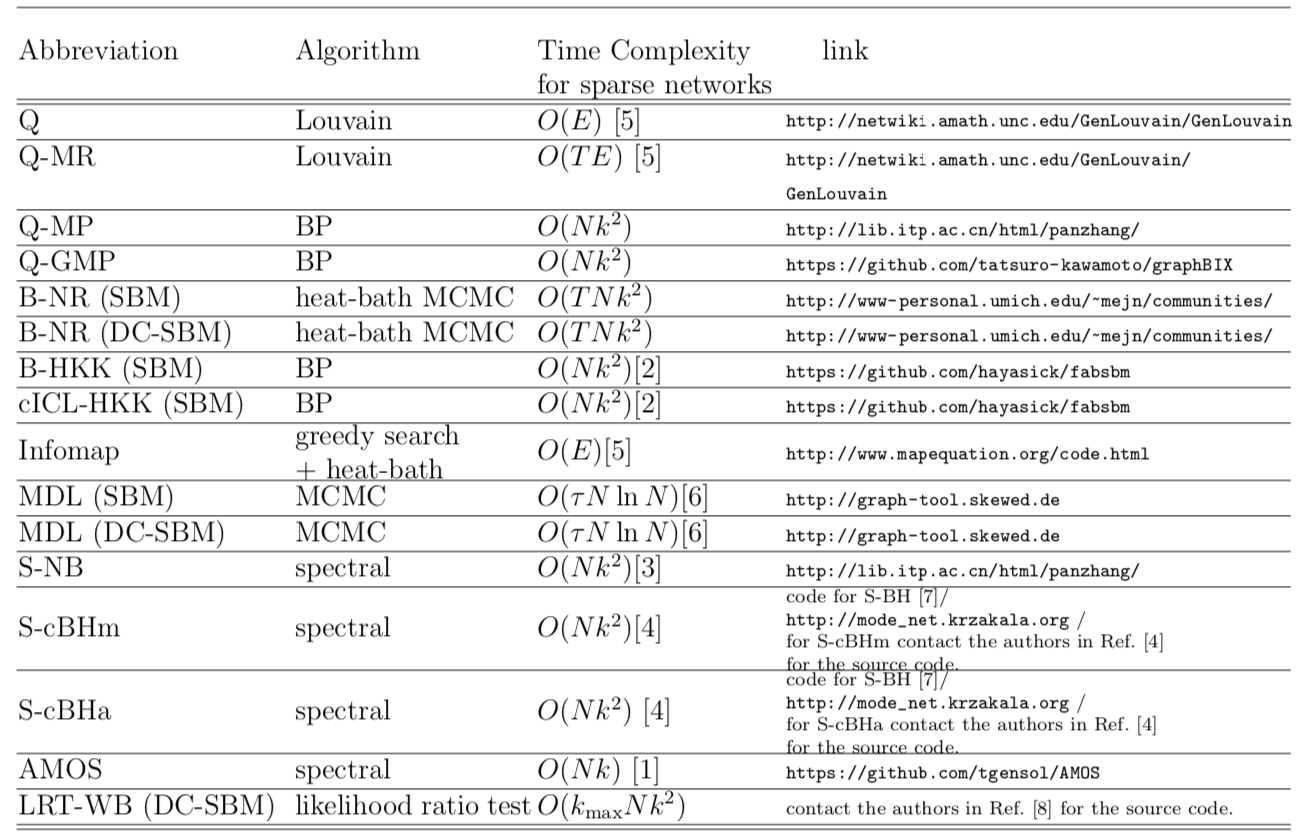

In [172]:
labels = ["labels_AMOS", "labels_B_HKK_SBM","labels_B_NR_DCSBM",
           "labels_B_NR_SBM","labels_Infomap", "labels_LRT_WB_DCSBM",
            "labels_MDL_DCSBM", "labels_Q_GMP", "labels_Q_MP",
            "labels_S_NB", "labels_S_cBHa", "labels_S_cBHm", 
            "labels_cICL_HKK_SBM"]


In [173]:
d = df.iloc[49]
n = len(d["nodes_id"])
A = edgelist_to_adj(d["edges_id"], n)


In [205]:
least_regret = None 
score = 101
scores = []
for name in labels: 
    part = get_partition(d[name], n)
    print(name, len(part))
    uni, block, opt = compute(A, part, 0.90)
    uni_r, block_r = regrets(uni, block, opt)
    scores.append(  (name, block_r) )
    if(block_r < score ):
        score = block_r
        least_regret = name 


labels_AMOS 148
labels_B_HKK_SBM 7
labels_B_NR_DCSBM 27
labels_B_NR_SBM 27
labels_Infomap 57
labels_LRT_WB_DCSBM 146
labels_MDL_DCSBM 17
labels_Q_GMP 14
labels_Q_MP 7
labels_S_NB 21
labels_S_cBHa 24
labels_S_cBHm 21
labels_cICL_HKK_SBM 2


In [175]:
scores.sort(key =  lambda x : x[1])

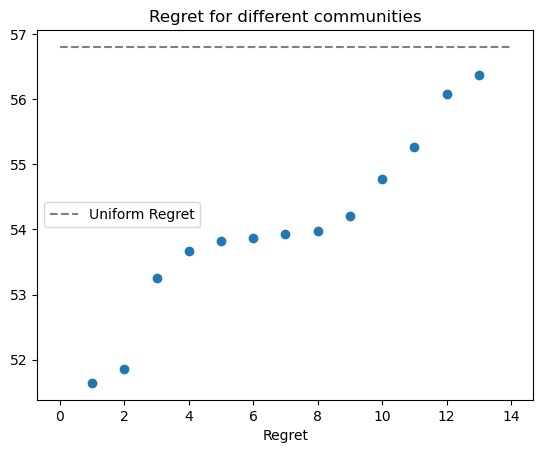

In [196]:
plt.scatter([i+1 for i in range(len(scores))], [s[1] for s in scores] )
plt.hlines(uni_r, xmin=0, xmax=14, label="Uniform Regret", color="gray", linestyles="--")
plt.title("Regret for different communities")
plt.xlabel("Regret")
plt.legend(loc="center left")

In [158]:
scores

[('labels_LRT_WB_DCSBM', 51.64100449189986),
 ('labels_B_NR_SBM', 51.848057332524036),
 ('labels_B_HKK_SBM', 53.24965003921183),
 ('labels_B_NR_DCSBM', 53.666469927145954),
 ('labels_Infomap', 53.82324979885589),
 ('labels_S_NB', 53.86459233024927),
 ('labels_S_cBHa', 53.92546223664786),
 ('labels_S_cBHm', 53.982966756902904),
 ('labels_Q_GMP', 54.20432621463122),
 ('labels_MDL_DCSBM', 54.76817601818311),
 ('labels_cICL_HKK_SBM', 55.267140808007376),
 ('labels_AMOS', 56.07787876509233),
 ('labels_Q_MP', 56.367122580506866)]

In [153]:
least_regret

'labels_LRT_WB_DCSBM'

In [154]:
score

51.64100449189986

In [203]:
uni_r

56.8051821504862

## Pol blogs

In [231]:
G = nx.read_gml("../data/polblogs.gml")
n = len(G)

In [303]:
A = nx.adjacency_matrix(G).todense()
A = np.asarray(A)
H = nx.Graph(A+A.T)

partI = np.eye(n,n)

/var/folders/19/v976smp1427fy96lbd0y82ym0000gn/T/ipykernel_84640/3198476768.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).todense()


In [304]:
compute(A, partI, .9)

(1280.296000531947, 2480.9336357506145, 2480.933635750615)

In [305]:
A.shape

(1490, 1490)

In [306]:
n_cls =  [2]

block_scores = [] 
for n_cl in n_cls: 
    print(n_cl)
    cluster =  skclust.KMeans(n_clusters=n_cl,n_init=5).fit_predict(A)
    part = np.zeros((n_cl, n))
    for i in range(n):
        cl = cluster[i]
        part[cl, i] = 1 
    uni, block, opt = compute(A, part, 0.90)
    uni_r, block_r = regrets(uni, block, opt )
    block_scores.append(block_r)

2


In [247]:
block_scores, uni_r

([48.16277183953424,
  47.76445716207762,
  47.40065415383058,
  47.183070485022526,
  46.73364450864641,
  46.590899167466446],
 48.394588953017724)

In [313]:
rho = 0.9/norm(A+A.T,ord=2)
B = inv(np.eye(n,n) - 2*rho*A)
randomPart = np.zeros((2,n))
for i in range(n):
    randomPart[np.random.randint(0,2), i] = 1 
max_trials = 10
i = 0
while(i < max_trials):
    if(i % 10 == 0):
        print(i)
    best = -1
    best_score = 0
    for col in range(n):
        swap(randomPart, col)
        score = just_block(B, randomPart)
        if(score > best_score):
            best = randomPart.copy()
            best_score = score 
        swap(randomPart, col)
    if(best_score == 0):
        break 
    i+= 1

0


In [302]:
def swap(A, col):
    temp = A[0,col]
    A[0,col] = A[1,col] 
    A[1,col] = temp 

swap(randomPart, 0) 
randomPart

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 1., 1., 1.]])

In [255]:
compute(A, randomPart, 0.9)

(1280.296000531947, 1280.7522440098837, 2480.933635750615)

In [253]:
uni, block, opt = compute(A, part, 0.90)
block

1286.4174635004501

In [289]:
partPol = [[],[]]
j = 0
for i in G:
    partPol[G.nodes[i]["value"]].append(j)
    j += 1

In [285]:
a = set(partPol[0])
b = set(partPol[1])
a.intersection(b)

set()

In [291]:
nx_comm.modularity(H, partPol)

0.41111803080138376